In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import sys
sys.path.append('/content/drive/MyDrive/thesis/models')

In [3]:
import pandas as pd
import numpy as np
import tensorflow as tf
import string
from tensorflow.keras import layers
from utility import process_md_lines

In [4]:
training_lines = open('/content/drive/MyDrive/thesis/models/dataset_splits/training.txt','r',encoding='utf-8').readlines()
testing_lines = open('/content/drive/MyDrive/thesis/models/dataset_splits/testing.txt','r',encoding='utf-8').readlines()
validation_lines = open('/content/drive/MyDrive/thesis/models/dataset_splits/validation.txt','r',encoding='utf-8').readlines()

In [5]:
training_df = process_md_lines(training_lines)
testing_df = process_md_lines(testing_lines)
validation_df = process_md_lines(validation_lines)

In [6]:
training_df.describe()

,id,order,total_lines
count,296725.000000,296725.000000,296725.000000
mean,507.400297,37.969056,76.938111
std,269.497433,31.086150,37.675229
min,0.000000,0.000000,1.000000
25%,283.000000,14.000000,52.000000
50%,542.000000,31.000000,73.000000
75%,732.000000,55.000000,98.000000
max,1082.000000,255.000000,256.000000


In [7]:
tclasses = training_df['label'].unique()
no_classes = len(tclasses)
no_classes

5

In [8]:
''' df = df.sample(frac=1.0, random_state=101)
cut_off = int(len(df)*0.7) '''
cut_off = int(len(training_df)*0.5)
train_df = training_df[:cut_off]
test_df = testing_df[:(int(len(testing_df)*0.5))]
validation_df = validation_df[:(int(len(validation_df)*0.5))]

In [9]:
train_df.describe()

,id,order,total_lines
count,148362.000000,148362.000000,148362.000000
mean,502.474387,37.730045,76.462389
std,270.297556,30.875696,37.395801
min,0.000000,0.000000,1.000000
25%,279.000000,13.000000,51.000000
50%,529.000000,31.000000,73.000000
75%,731.000000,55.000000,98.000000
max,1082.000000,255.000000,256.000000


In [10]:
X_train = train_df['text'].to_numpy()
X_test = test_df['text'].to_numpy()
X_validation = validation_df['text'].to_numpy()

In [11]:
y_train = pd.get_dummies(train_df['label']).to_numpy()
y_test = pd.get_dummies(test_df['label']).to_numpy()
y_validation = pd.get_dummies(validation_df['label']).to_numpy()

In [12]:
vocab = set()
count = 0
char_count = 0
for text in train_df['text'].to_numpy():
    tokens = text.split()
    vocab.update(tokens)
    count+=len(tokens)
    char_count+= len(text)



In [13]:
VOCAB_SIZE = len(vocab)
VOCAB_SIZE

61988

In [14]:
tokens_lens = [len(sentence.split()) for sentence in train_df['text'].to_numpy()]
SEQ_LENGTH = int(np.percentile(tokens_lens, 95))
SEQ_LENGTH

49

In [15]:
BATCH_SIZE = 32
WORD_EMBED_SIZE = 128

In [16]:
text_vectorizer = tf.keras.layers.experimental.preprocessing.TextVectorization(max_tokens=VOCAB_SIZE, output_sequence_length=SEQ_LENGTH)

In [17]:
text_vectorizer.adapt(train_df['text'].to_numpy())

In [18]:
embedding = tf.keras.layers.Embedding(
    VOCAB_SIZE,
    WORD_EMBED_SIZE,
    mask_zero=True
)

In [19]:
model = tf.keras.models.Sequential([
    layers.Input(shape=[], dtype=tf.string),
    text_vectorizer,
    embedding,
    layers.Bidirectional(layers.LSTM(64, return_sequences=True)),
    layers.Dropout(0.2),
    layers.Bidirectional(layers.LSTM(64)),
    #layers.Dense(128, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(no_classes, activation='softmax')
])

In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, 49)               0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 49, 128)           7934464   
                                                                 
 bidirectional (Bidirectiona  (None, 49, 128)          98816     
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 49, 128)           0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 128)              98816     
 nal)                                                            
                                                        

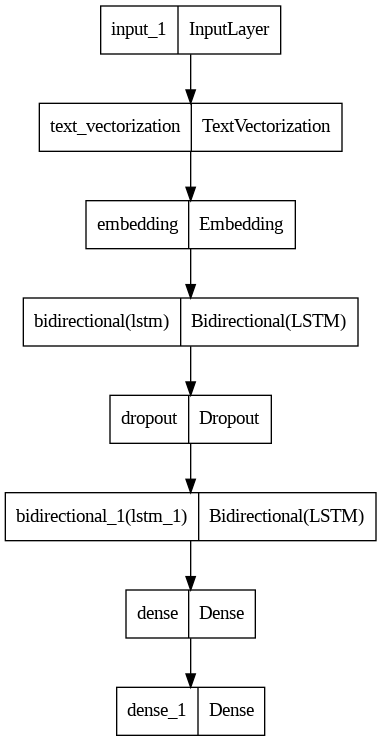

In [21]:
from tensorflow.keras.utils import plot_model
plot_model(model)

In [22]:
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [23]:
opt = tf.keras.optimizers.Adam(learning_rate=0.01)

In [24]:
model.compile(loss="categorical_crossentropy",optimizer=opt, metrics=['accuracy'])

In [25]:
es = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=5,
    verbose=0,
    mode="auto",
    baseline=None,
    restore_best_weights=False)

In [ ]:
model.fit(train_ds, validation_data=test_ds, epochs=10, callbacks=[es])

Epoch 1/10
4637/4637 [==============================] - 950s 201ms/step - loss: 0.6945 - accuracy: 0.7662 - val_loss: 0.6109 - val_accuracy: 0.7938
Epoch 2/10
4637/4637 [==============================] - 930s 201ms/step - loss: 0.5370 - accuracy: 0.8254 - val_loss: 0.5989 - val_accuracy: 0.8044
Epoch 3/10
4637/4637 [==============================] - 949s 205ms/step - loss: 0.5117 - accuracy: 0.8348 - val_loss: 0.5998 - val_accuracy: 0.8056
Epoch 4/10
  36/4637 [..............................] - ETA: 14:30 - loss: 0.6555 - accuracy: 0.7778

In [ ]:
pd.DataFrame(model.history.history)[['loss','val_loss']].plot()

In [ ]:
model.evaluate(test_ds)

In [ ]:
#Test Dataset (10%)
preds = np.argmax(model.predict(X_test), axis=1)
cat_preds = tf.keras.utils.to_categorical(preds,dtype='int') #convert categorical to sparse 
from sklearn.metrics import classification_report
print(classification_report(y_test, cat_preds))

In [ ]:
#Validation Dataset ( 10% )
preds_validation = np.argmax(model.predict(X_validation), axis=1)
cat_preds = tf.keras.utils.to_categorical(preds_validation,dtype='int') #convert categorical to sparse 
from sklearn.metrics import classification_report
print(classification_report(y_validation, cat_preds))

In [ ]:
r = np.random.randint(0,len(X_train))
text = X_train[r]
true_pred = y_train[r]
print(text)
print(true_pred)
true_pred_ = np.argmax(true_pred)
print(true_pred_)

In [ ]:
myTensor = tf.convert_to_tensor(text, dtype=tf.string) 
myTensor = tf.expand_dims(myTensor,axis=-1)
class_index = np.argmax(model(myTensor))
class_index